<a href="https://colab.research.google.com/github/Khalid-Rafiq-01/Image-Segmentation-Pets-Datset/blob/main/TF_Input_PipeLine_(5500_patches).ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

The main objective of this workbook is:
1. Tackling the limitation of the last workbook with regards to handling large data without running into RAM issues.
2. **Developing a tensorflow input pipeline, that takes data from the disc in batches and keeps training the model parallely i.e creating efficient pipeline.**
3. Training this tensorflow dataset using the standard UNet.
4. Traning the tensorflow pipeline on UNet with **pretrained ResNet34 Encoder** and **pretrained EfficientNetB7 Encoder.**
5. Testing the trained model(ResNet34) on an online image containing two cats instead of one.
6. Making a comparision of pretrained ResNet50 model based on reshape method with the pretrained ResNet34 model trainied on only ~ 1500 patches with the pretrained ResNet34 model trainied on almost ~ 5500 patches.

In [ ]:
# Importing necessary modules:
import numpy as np
import cv2
import os
import matplotlib.pyplot as plt

from sklearn.preprocessing import MinMaxScaler, StandardScaler
scaler = MinMaxScaler()

import matplotlib.pyplot as plt
import numpy as np
import tensorflow as tf

import tensorflow_datasets as tfds
import random
from keras.utils import to_categorical

In [ ]:
train_img_dir = ("/content/drive/MyDrive/Data Segmentation Pets/train_images/train")
train_mask_dir = ("/content/drive/MyDrive/Data Segmentation Pets/train_masks/train")

In [ ]:
# Let us count the number of numpy arrays (images and masks and sort these numpy arrays):
img_list = os.listdir(train_img_dir)
img_list.sort()
msk_list = os.listdir(train_mask_dir)
msk_list.sort()

num_images = len(img_list)
num_masks = len(msk_list)
print(f'The number of images in the drive is: {num_images}')
print(f'The number of masks in the drive is: {num_masks}')

The number of images in the drive is: 5307
The number of masks in the drive is: 5307


In [ ]:
# Writing a code to extract the path of all the training images and masks: 
img_paths = []
mask_paths = []
for i in range(len(img_list)):
  img_paths.append(f'{train_img_dir}/image_{i}.npy')
  mask_paths.append(f'{train_mask_dir}/mask_{i}.npy')
print(img_paths)
print(mask_paths)

['/content/drive/MyDrive/Data Segmentation Pets/train_images/train/image_0.npy', '/content/drive/MyDrive/Data Segmentation Pets/train_images/train/image_1.npy', '/content/drive/MyDrive/Data Segmentation Pets/train_images/train/image_2.npy', '/content/drive/MyDrive/Data Segmentation Pets/train_images/train/image_3.npy', '/content/drive/MyDrive/Data Segmentation Pets/train_images/train/image_4.npy', '/content/drive/MyDrive/Data Segmentation Pets/train_images/train/image_5.npy', '/content/drive/MyDrive/Data Segmentation Pets/train_images/train/image_6.npy', '/content/drive/MyDrive/Data Segmentation Pets/train_images/train/image_7.npy', '/content/drive/MyDrive/Data Segmentation Pets/train_images/train/image_8.npy', '/content/drive/MyDrive/Data Segmentation Pets/train_images/train/image_9.npy', '/content/drive/MyDrive/Data Segmentation Pets/train_images/train/image_10.npy', '/content/drive/MyDrive/Data Segmentation Pets/train_images/train/image_11.npy', '/content/drive/MyDrive/Data Segmenta

*Sanity check by visualizing a random image and a mask*

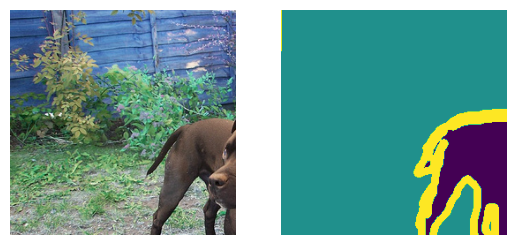

In [ ]:
num = np.random.randint(0, len(img_list))
img = np.load(img_paths[num])
mask = np.load(mask_paths[num])

plt.subplot(121)
plt.imshow(img)
plt.axis('off')
plt.subplot(122)
plt.imshow(mask)
plt.axis('off')
plt.show()


*Now we have created list of train images and masks. Let us define functions that loads an image and a mask* 

In [ ]:
# Function takes in an image
def load_image(img_path):
  x = np.load(img_path)
  x = x.astype('float32')
  return x

def load_mask(mask_path):
  y = np.load(mask_path)
  y = to_categorical(y, 3)
  y = y.astype('float32')
  return y

In [ ]:
H = 256 # Height of the patch
W = 256 # Width of the patch
def preprocess(x, y):
    def f(x, y):
        x = x.decode()
        y = y.decode()

        image = load_image(x)
        mask = load_mask(y)

        return image, mask
    image, mask = tf.numpy_function(f, [x, y], [tf.float32, tf.float32])
    image.set_shape([H, W, 3])
    mask.set_shape([H, W, 3])
    
    return image, mask

In [ ]:
## Let us develop our tensorflow api pipeline which takes in train for image and masks!
def tf_dataset(image_paths, mask_paths, batch):
    dataset = tf.data.Dataset.from_tensor_slices((image_paths, mask_paths))
    dataset = dataset.shuffle(buffer_size=20000)
    dataset = dataset.repeat()
    dataset = dataset.map(preprocess)
    dataset = dataset.batch(batch)
    dataset = dataset.prefetch(10)
    return dataset

In [ ]:
train_dataset = tf_dataset(img_paths, mask_paths, batch=16) # Creating a batchsize of 16

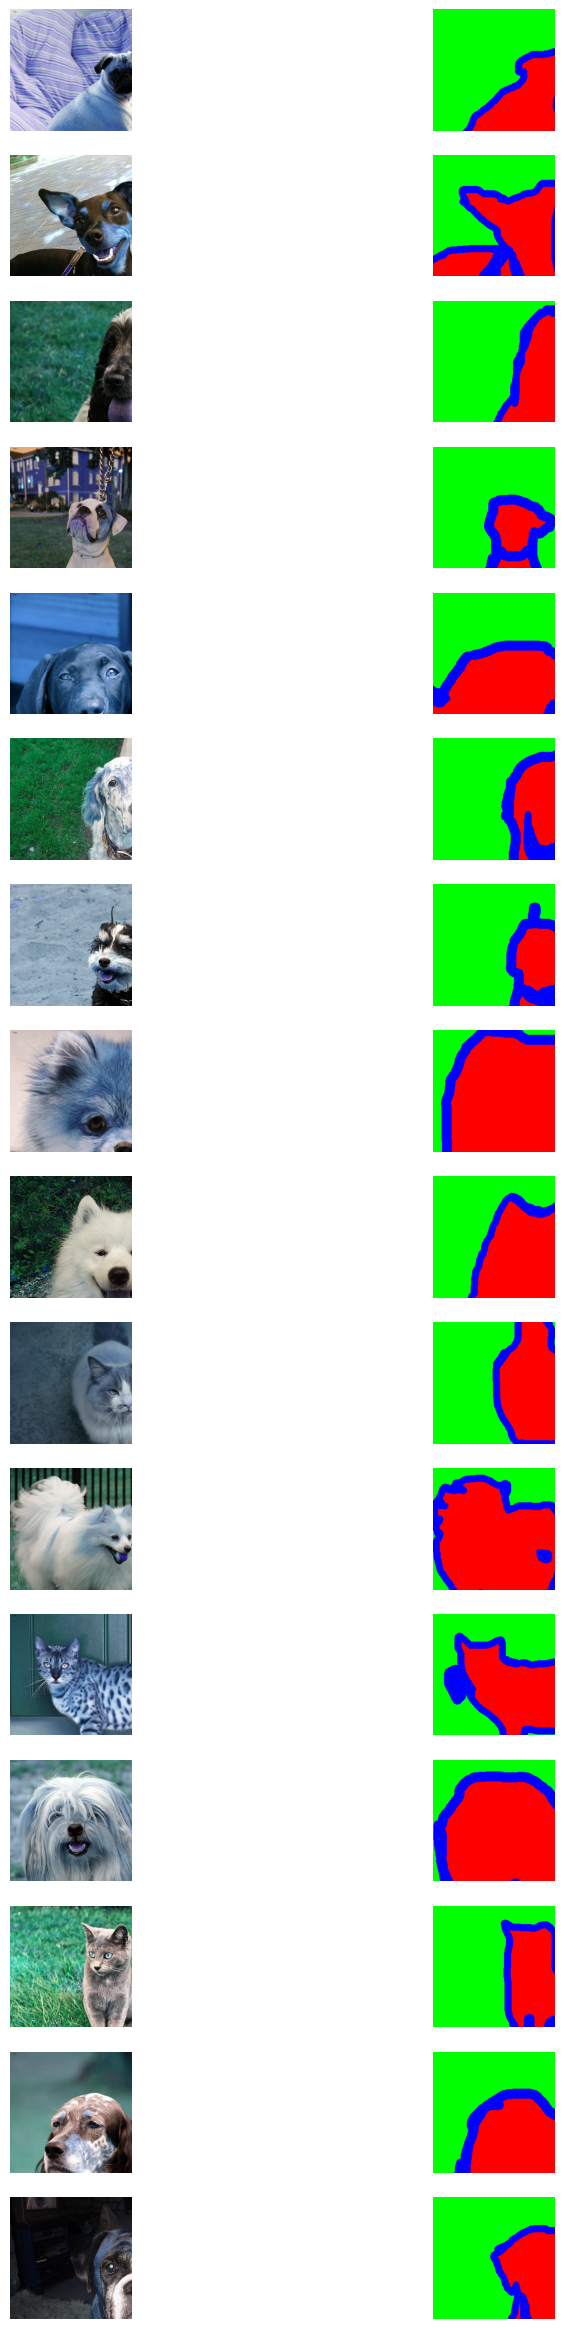

In [ ]:
fig, axes = plt.subplots(nrows=16, ncols=2, figsize=(10,30))
for images, masks in train_dataset.take(1):
  for i in range(16):
    axes[i, 0].imshow(images[i])
    axes[i, 0].axis('off')

    axes[i, 1].imshow(masks[i])
    axes[i, 1].axis('off')

In [ ]:
val_img_dir = ('/content/drive/MyDrive/Data Segmentation Pets/val_images/val')
val_img_mask = ('/content/drive/MyDrive/Data Segmentation Pets/val_masks/val')

In [ ]:
# write a code that extrats name of all the images, masks within the directory
val_images = sorted(os.listdir(val_img_dir))
val_masks = sorted(os.listdir(val_img_mask))
num = len(val_images)
print(f'Number of images in validation dataset: {len(val_images)}')
print(f'Number of masks in the validation dataset: {len(val_masks)}')


Number of images in validation dataset: 282
Number of masks in the validation dataset: 282


In [ ]:
# write a code that sttes the path of each onthe image in the directory:
val_images_path_list = []
val_masks_path_list = []
for i in range(num):
  val_images_path_list.append(f'{val_img_dir}/image_{i}.npy')
  val_masks_path_list.append(f'{val_img_mask}/mask_{i}.npy')

*Checking a random image and corrosponding mask* 

(-0.5, 255.5, 255.5, -0.5)

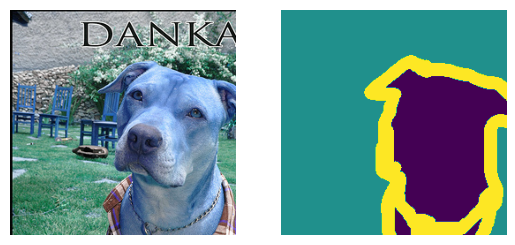

In [ ]:
rand = np.random.randint(0, num)
plt.subplot(121)
plt.imshow(np.load(val_images_path_list[rand]))
plt.axis('off')
plt.subplot(122)
plt.imshow(np.load(val_masks_path_list[rand]))
plt.axis('off')

In [ ]:
# Pass this validation data into the tesnorflow datasets:
validation_dataset = tf_dataset(val_images_path_list, val_masks_path_list, batch=16)

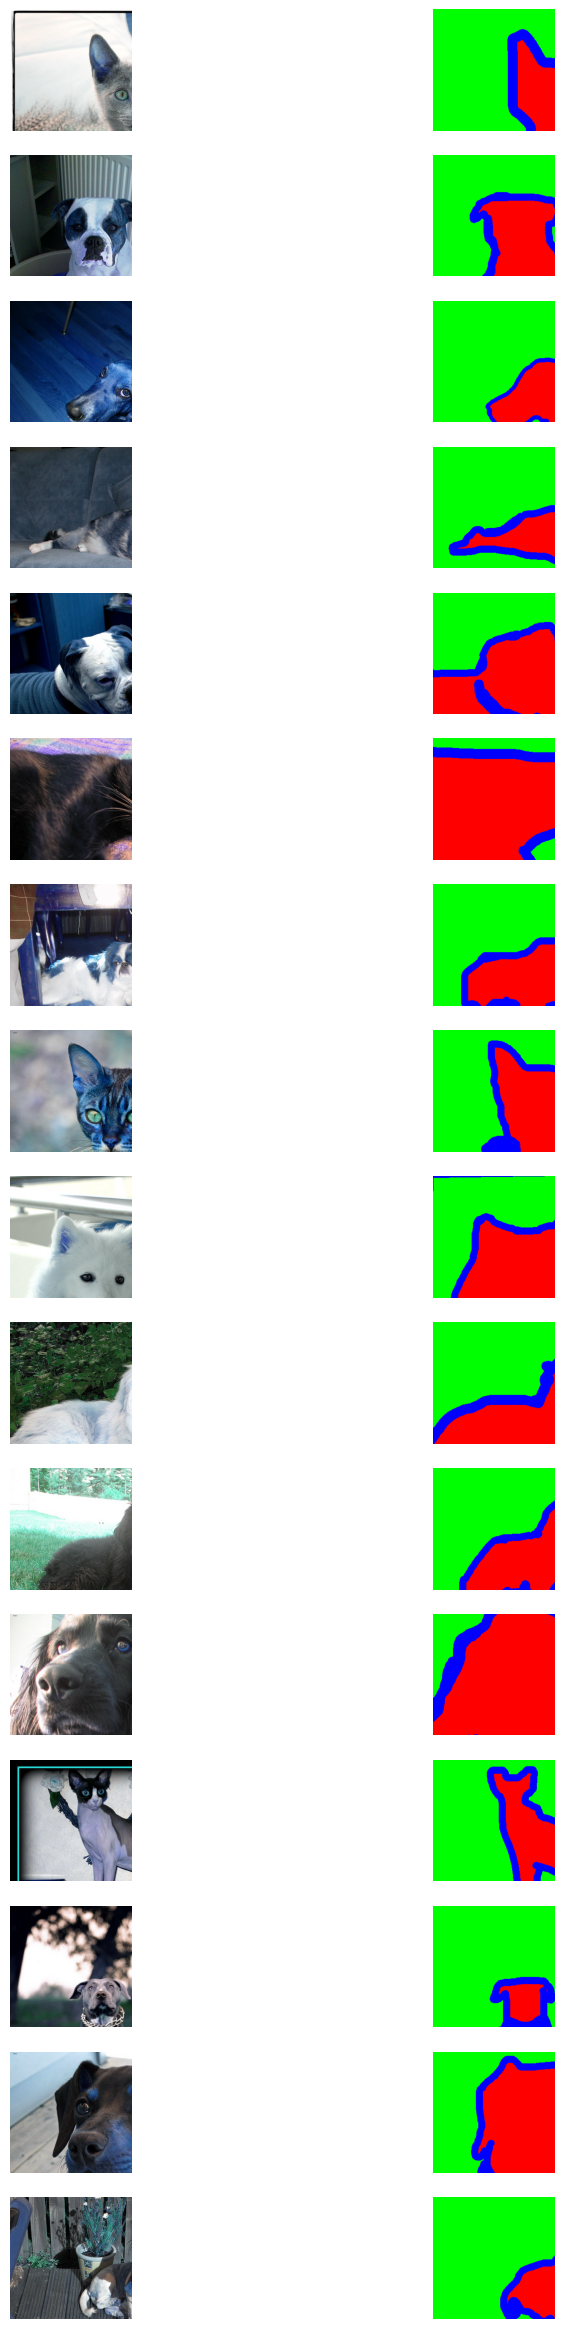

In [ ]:
fig, axes = plt.subplots(nrows = 16, ncols = 2, figsize=(10,30))

for images, masks in validation_dataset.take(1):
  for i in range(16):
    axes[i, 0].imshow(images[i])
    axes[i, 0].axis('off')

    axes[i, 1].imshow(masks[i])
    axes[i, 1].axis('off')

In [ ]:
batch_size = 16
train_steps = len(img_paths)//batch_size   # 1579//4 --_> (number of batches for traning)
valid_steps = len(val_images_path_list)//batch_size   ## ---> (number of batches for validation)

*The data - pipeline has been created*

**Now we will work on the model architecture**

In [ ]:
# importing the necessary libraries:
import tensorflow as tf
from tensorflow import keras
from keras.layers import Conv2D, MaxPooling2D, Activation, Conv2DTranspose, Input, Dropout, BatchNormalization
from keras.models import Model

In [ ]:
classes = 3
image_height = H
image_width = W
channels = 3

In [ ]:
# Defining basic functions for developing the UNet Model----: (# Adding Normalization to the UNet model)
# Let us first define the convolution block: 2*(3,3) convs. Both conv have same num_filters:

def conv_block(input, num_filters):
  x = Conv2D(filters = num_filters, kernel_size = (3,3), kernel_initializer='he_normal', padding='same')(input)
  x = BatchNormalization()(x) # Adding a batch_normalization layer
  x = Activation('relu')(x)

  x = Conv2D(filters = num_filters, kernel_size = (3,3), kernel_initializer='he_normal', padding='same')(x)
  x = BatchNormalization()(x) # Adding a batch_normalization layer
  x = Activation('relu')(x)
  return x

# Let us now define the Encoding Block:
def encoder_block(input, num_filters):
  x = conv_block(input, num_filters)
  p = MaxPooling2D(pool_size=(2, 2))(x)
  return x, p

# Let us now define the Decoding Block: up conv (2,2) --> Concatination --> (3,3) ReLu convs
def decoder_block(inputs, skip_features, num_filters):
  x = Conv2DTranspose(filters=num_filters, kernel_size=(2,2), strides=2, padding='same')(inputs)
  x = keras.layers.concatenate([x, skip_features])
  x = conv_block(x, num_filters)
  return x

In [ ]:
# Building the basic U-Net Model:

def basic_unet_model(classes, image_height, image_width, channels):
  # Defining the input:
  inputs = Input((image_height, image_width, channels))
  #Creating and augmentation layer:
  #x = image_augment(inputs)

  # Defining the Encoding section: 
  s1, p1 = encoder_block(inputs, 16) # s will be used for skip outputs for concatination #(256,256)
  s2, p2 = encoder_block(p1, 32)     # (128,128)
  s3, p3 = encoder_block(p2, 64)     # (64,64)
  s4, p4 = encoder_block(p3, 128)    #  (32,32) ---> (16,16,128)


  # Bridge:
  b1 = conv_block(p4,256)   # (8,8,512)


  # Decoder:
  d1 = decoder_block(b1,s4,128)   # observe that size(s1)
  d2 = decoder_block(d1,s3,64)
  d3 = decoder_block(d2,s2,32)
  d4 = decoder_block(d3,s1,16)

  # Output:
  outputs = Conv2D(filters = classes, kernel_size = 1, padding = "same", activation = "softmax")(d4)

  # Compiling the Model:
  model = Model(inputs=inputs, outputs=outputs)
  return model

# Getting the basic Unet Model:

def get_basic_unet_model():
  return basic_unet_model(classes=classes, 
                    image_height=image_height, 
                    image_width=image_width, 
                    channels=channels)
basic_model = get_basic_unet_model()
basic_model.summary()

Model: "model_2"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 256, 256, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv2d (Conv2D)                (None, 256, 256, 16  448         ['input_1[0][0]']                
                                )                                                                 
                                                                                                  
 batch_normalization (BatchNorm  (None, 256, 256, 16  64         ['conv2d[0][0]']                 
 alization)                     )                                                           

In [ ]:
from keras.optimizers import Adam
lr = 0.0005

In [ ]:
basic_model.compile(optimizer = Adam(learning_rate=lr), loss="categorical_crossentropy", metrics = ['accuracy'])
callbacks = [
    keras.callbacks.ModelCheckpoint("pets_segmentation_basic_tile.h5", save_best_only=True)
]

In [ ]:
history = basic_model.fit(train_dataset,
        steps_per_epoch=train_steps,
        validation_data=validation_dataset,
        validation_steps=valid_steps,
        epochs=10,
        callbacks=callbacks
    )

Epoch 1/10
331/331 [==============================] - 110s 315ms/step - loss: 0.6709 - accuracy: 0.7317 - val_loss: 0.7692 - val_accuracy: 0.7475
Epoch 2/10
331/331 [==============================] - 101s 306ms/step - loss: 0.4496 - accuracy: 0.8309 - val_loss: 0.4312 - val_accuracy: 0.8412
Epoch 3/10
331/331 [==============================] - 102s 307ms/step - loss: 0.3932 - accuracy: 0.8509 - val_loss: 0.4955 - val_accuracy: 0.8304
Epoch 4/10
331/331 [==============================] - 100s 303ms/step - loss: 0.3520 - accuracy: 0.8668 - val_loss: 0.3431 - val_accuracy: 0.8705
Epoch 5/10
331/331 [==============================] - 105s 316ms/step - loss: 0.3318 - accuracy: 0.8743 - val_loss: 0.3294 - val_accuracy: 0.8740
Epoch 6/10
331/331 [==============================] - 102s 309ms/step - loss: 0.3103 - accuracy: 0.8822 - val_loss: 0.3346 - val_accuracy: 0.8767
Epoch 7/10
331/331 [==============================] - 99s 300ms/step - loss: 0.2927 - accuracy: 0.8886 - val_loss: 0.3363 - 

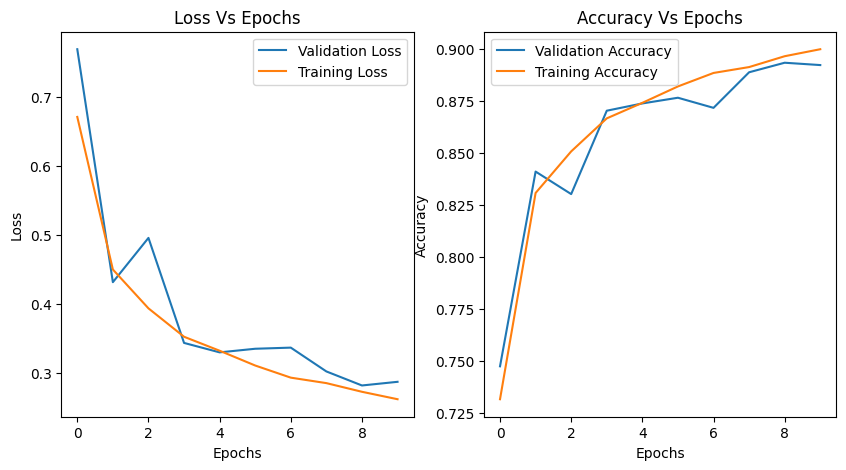

In [ ]:
# Plotting the Validation Loss N Validation Accuracy against the number of Epochs:
import pandas as pd
data = pd.DataFrame(history.history)
(a,b) = data.shape

plt.figure(figsize=(10,5))
plt.subplot(1,2,1)
plt.plot(range(a), data['val_loss'], label = "Validation Loss")
plt.plot(range(a), data['loss'], label = "Training Loss")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.title("Loss Vs Epochs")
plt.legend()

plt.subplot(1,2,2)
plt.plot(range(a), data['val_accuracy'], label = "Validation Accuracy")
plt.plot(range(a), data['accuracy'], label = "Training Accuracy")
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.title("Accuracy Vs Epochs")
plt.legend()

In [ ]:
from keras.models import load_model
model_path = '/content/pets_segmentation_basic_tile.h5'
model = load_model(model_path)

In [ ]:
test_images_list = []
test_masks_list = []

for images, masks in validation_dataset.take(10):
    for i in range(images.shape[0]):
        img = images[i]
        mask = masks[i]
        test_images_list.append(img)
        test_masks_list.append(mask)

*We need to store these out and then run our predictions on them. If we do not do that and run .take() first here and then on model.predict, we will get differnt images due to shuffling*

In [ ]:
# Saving the data in numpy arrays
test_dataset_images = np.array(test_images_list)
test_dataset_masks = np.array(test_masks_list)

*Now we need to transform the above daat in same format as expected by the model, ie a tf.dataset*

In [ ]:
test_dataset = tf.data.Dataset.from_tensor_slices((test_dataset_images))

In [ ]:
# Now we need to convert from TensorSliceDataset to BatchDataset as expected by the model:
dataset = test_dataset.batch(batch_size=1)

In [ ]:
print(type(dataset))

<class 'tensorflow.python.data.ops.batch_op._BatchDataset'>


*Now the images are in the format as expected by the model*

In [ ]:
predicted_masks = model.predict(dataset)

160/160 [==============================] - 2s 4ms/step


In [ ]:
print(predicted_masks.shape)

(160, 256, 256, 3)


*Plotting the images*

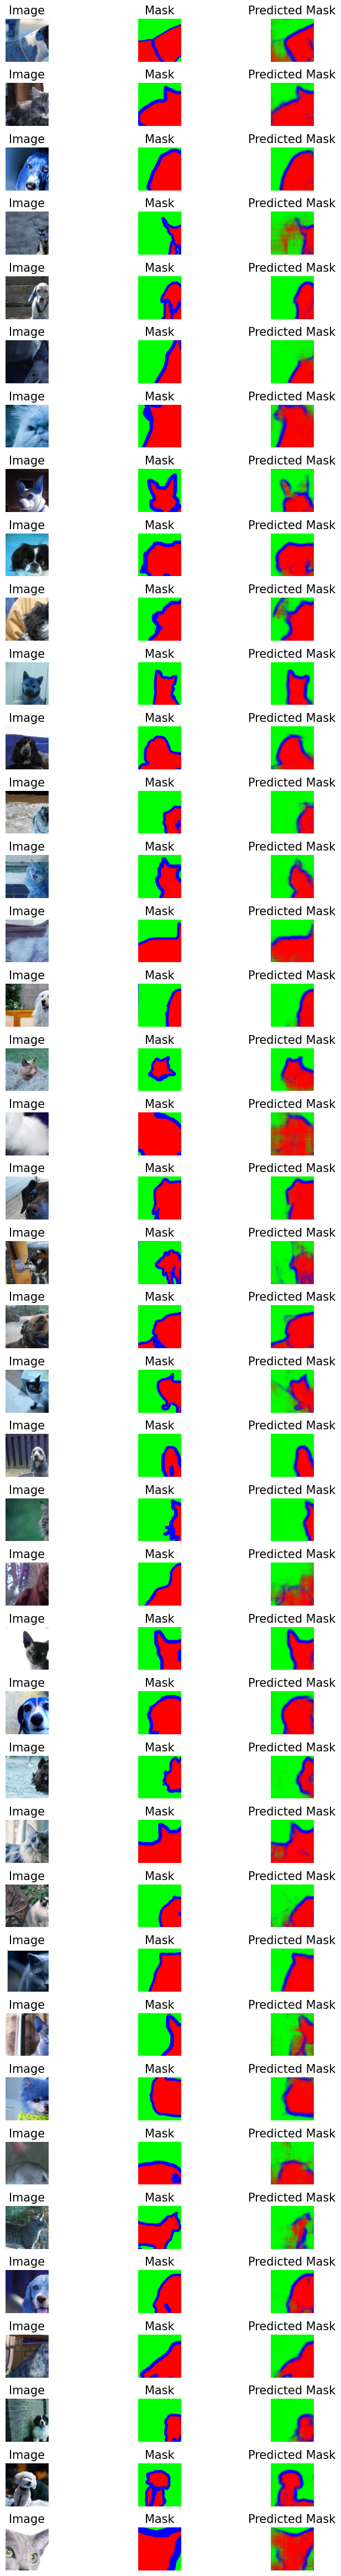

In [ ]:
# Define the size of each subplot image
subplot_size = (3, 3)
figsize = (subplot_size[0]*3, subplot_size[1]*20)

# Iterate over the first 20 images, True masks and predicted masks
fig, axes = plt.subplots(nrows=40, ncols=3, figsize=figsize)

for i in range(40):
    # Plot the image on the top row of the subplot
    axes[i, 0].imshow(test_dataset_images[i])
    axes[i, 0].set_title('Image', fontsize=15)
    axes[i, 0].axis('off')

    # Plot the mask on the middle row of the subplot
    axes[i, 1].imshow(test_dataset_masks[i])
    axes[i, 1].set_title('Mask', fontsize=15)
    axes[i, 1].axis('off')

    # Plot the predicted mask on the bottom row of the subplot
    axes[i, 2].imshow(predicted_masks[i])
    axes[i, 2].set_title('Predicted Mask', fontsize=15)
    axes[i, 2].axis('off')

# Adjust the size and spacing of the subplots
fig.subplots_adjust(hspace=0.5, wspace=0.1)


# Show the plot
plt.show()

# Using a Pretrained Resnet34 Encoder Backbone!

In [ ]:
 !pip install -U segmentation-models

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


*Importing necessary libraries*

In [ ]:
import os
os.environ["SM_FRAMEWORK"] = "tf.keras"

from tensorflow import keras
import segmentation_models as sm

Segmentation Models: using `tf.keras` framework.


In [ ]:
###Model 
BACKBONE = 'resnet34'


In [ ]:
batch_size = 16
train_steps = len(img_paths)//batch_size   # 1579//4 --_> (number of batches for traning)
valid_steps = len(val_images_path_list)//batch_size   ## ---> (number of batches for validation)

In [ ]:
from keras.optimizers import Adam

In [ ]:
# define model
model = sm.Unet(BACKBONE, encoder_weights='imagenet', classes=classes, activation='softmax')

#model.compile
model.compile(optimizer = Adam(learning_rate=0.0001), loss='categorical_crossentropy', metrics=['accuracy'])

print(model.summary())

Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 data (InputLayer)              [(None, None, None,  0           []                               
                                 3)]                                                              
                                                                                                  
 bn_data (BatchNormalization)   (None, None, None,   9           ['data[0][0]']                   
                                3)                                                                
                                                                                                  
 zero_padding2d (ZeroPadding2D)  (None, None, None,   0          ['bn_data[0][0]']                
                                3)                                                          

In [ ]:
# Defining model callbacks:
from keras.callbacks import ModelCheckpoint
filepath = "block_tile_resnet34.h5"
callbacks_list = [ModelCheckpoint(filepath, save_best_only=True)]

In [ ]:
history = model.fit(train_dataset,
        steps_per_epoch=train_steps,
        validation_data=validation_dataset,
        validation_steps=valid_steps,
        epochs=15,
        callbacks=callbacks_list
    )

Epoch 1/15
331/331 [==============================] - 136s 347ms/step - loss: 0.4550 - accuracy: 0.8418 - val_loss: 1.3749 - val_accuracy: 0.5481
Epoch 2/15
331/331 [==============================] - 109s 328ms/step - loss: 0.2375 - accuracy: 0.9303 - val_loss: 0.4117 - val_accuracy: 0.8483
Epoch 3/15
331/331 [==============================] - 105s 317ms/step - loss: 0.1751 - accuracy: 0.9415 - val_loss: 0.1866 - val_accuracy: 0.9334
Epoch 4/15
331/331 [==============================] - 106s 319ms/step - loss: 0.1488 - accuracy: 0.9459 - val_loss: 0.1692 - val_accuracy: 0.9397
Epoch 5/15
331/331 [==============================] - 106s 319ms/step - loss: 0.1348 - accuracy: 0.9487 - val_loss: 0.1588 - val_accuracy: 0.9407
Epoch 6/15
331/331 [==============================] - 102s 308ms/step - loss: 0.1141 - accuracy: 0.9550 - val_loss: 0.1567 - val_accuracy: 0.9414
Epoch 7/15
331/331 [==============================] - 100s 304ms/step - loss: 0.1055 - accuracy: 0.9577 - val_loss: 0.1609 -

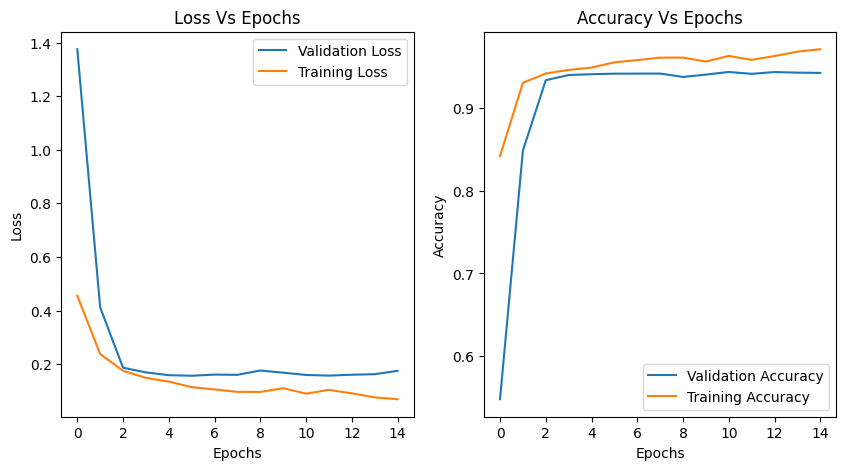

In [ ]:
# Plotting the Validation Loss N Validation Accuracy against the number of Epochs:
import pandas as pd
data = pd.DataFrame(history.history)
(a,b) = data.shape

plt.figure(figsize=(10,5))
plt.subplot(1,2,1)
plt.plot(range(a), data['val_loss'], label = "Validation Loss")
plt.plot(range(a), data['loss'], label = "Training Loss")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.title("Loss Vs Epochs")
plt.legend()

plt.subplot(1,2,2)
plt.plot(range(a), data['val_accuracy'], label = "Validation Accuracy")
plt.plot(range(a), data['accuracy'], label = "Training Accuracy")
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.title("Accuracy Vs Epochs")
plt.legend()

*Loading the model to check its pediction on the validation images:*

In [ ]:
from keras.models import load_model
model_path = '/content/block_tile_resnet34.h5'
model = load_model(model_path)

In [ ]:
test_images_list = []
test_masks_list = []

for images, masks in validation_dataset.take(10):
    for i in range(images.shape[0]):
        img = images[i]
        mask = masks[i]
        test_images_list.append(img)
        test_masks_list.append(mask)

*Changing the format of the validation images to match the format as expected by the model*

In [ ]:
# Saving the data in numpy arrays
test_dataset_images = np.array(test_images_list)
test_dataset_masks = np.array(test_masks_list)

In [ ]:
test_dataset = tf.data.Dataset.from_tensor_slices((test_dataset_images))

In [ ]:
# Now we need to convert from TensorSliceDataset to BatchDataset as expected by the model:
dataset = test_dataset.batch(batch_size=1)

In [ ]:
predicted_masks = model.predict(dataset)

320/320 [==============================] - 6s 10ms/step


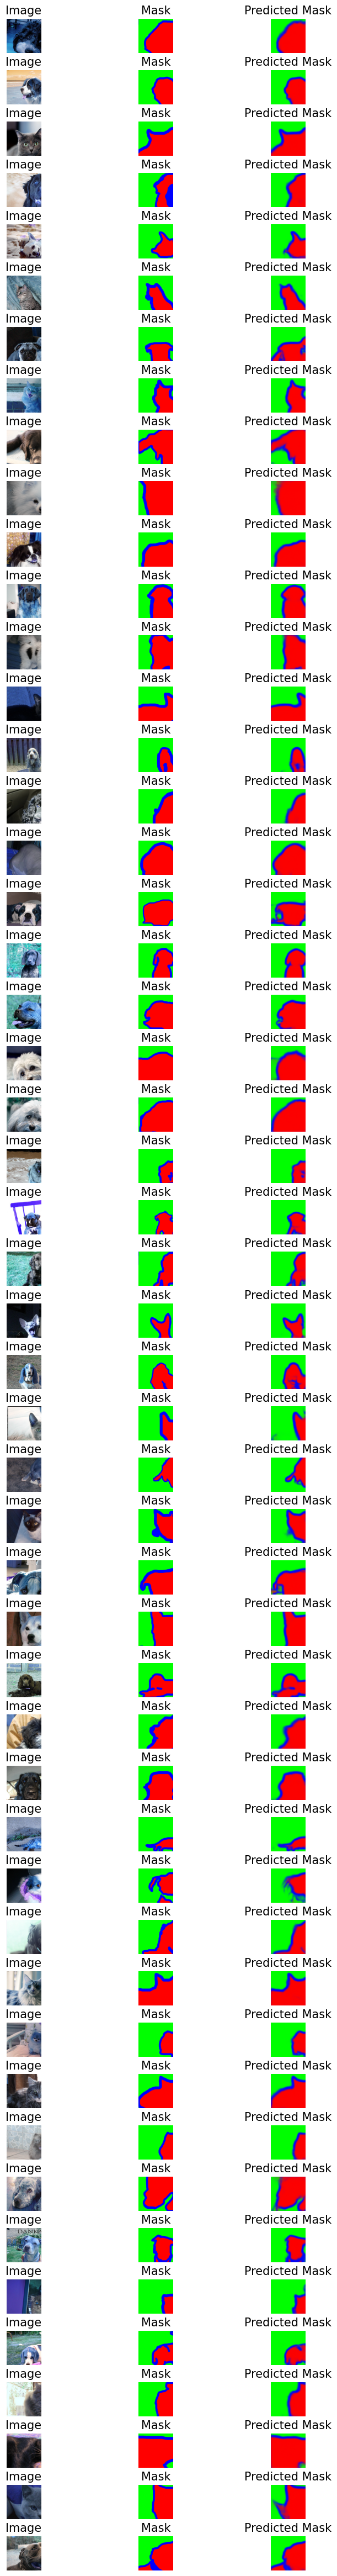

In [ ]:
# Define the size of each subplot image
subplot_size = (3, 3)
figsize = (subplot_size[0]*3, subplot_size[1]*20)

# Iterate over the first 20 images, True masks and predicted masks
fig, axes = plt.subplots(nrows=50, ncols=3, figsize=figsize)

for i in range(50):
    # Plot the image on the top row of the subplot
    axes[i, 0].imshow(test_dataset_images[i])
    axes[i, 0].set_title('Image', fontsize=15)
    axes[i, 0].axis('off')

    # Plot the mask on the middle row of the subplot
    axes[i, 1].imshow(test_dataset_masks[i])
    axes[i, 1].set_title('Mask', fontsize=15)
    axes[i, 1].axis('off')

    # Plot the predicted mask on the bottom row of the subplot
    axes[i, 2].imshow(predicted_masks[i])
    axes[i, 2].set_title('Predicted Mask', fontsize=15)
    axes[i, 2].axis('off')

# Adjust the size and spacing of the subplots
fig.subplots_adjust(hspace=0.5, wspace=0.1)


# Show the plot
plt.show()

#Working on EfficientNetB7 model

**We will freeze the weights due to computational resource limitations**

In [ ]:
# define model
BACKBONE = 'efficientnetb7'
model_b7_patch_frozen = sm.Unet(BACKBONE, encoder_weights='imagenet', classes=classes, activation='softmax', encoder_freeze=True)

#model.compile
model_b7_patch_frozen.compile(optimizer = Adam(learning_rate=0.0001), loss='categorical_crossentropy', metrics=['accuracy'])


258434480/258434480 [==============================] - 2s 0us/step


In [ ]:
# Defining model callbacks:
from keras.callbacks import ModelCheckpoint
filepath = "tile_b7_sm_model_frozen.h5"
callbacks_list = [ModelCheckpoint(filepath, save_best_only=True)]

In [ ]:
history_240_frozen_b7 = model_b7_patch_frozen.fit(train_dataset,
        steps_per_epoch=train_steps,
        validation_data=validation_dataset,
        validation_steps=valid_steps,
        epochs=20,
        callbacks=callbacks_list
    )

Epoch 1/20
602/602 [==============================] - 267s 377ms/step - loss: 0.3382 - accuracy: 0.8822 - val_loss: 0.1994 - val_accuracy: 0.9289
Epoch 2/20
602/602 [==============================] - 222s 369ms/step - loss: 0.1993 - accuracy: 0.9271 - val_loss: 0.1793 - val_accuracy: 0.9319
Epoch 3/20
602/602 [==============================] - 222s 369ms/step - loss: 0.1773 - accuracy: 0.9336 - val_loss: 0.1749 - val_accuracy: 0.9335
Epoch 4/20
602/602 [==============================] - 220s 365ms/step - loss: 0.1656 - accuracy: 0.9372 - val_loss: 0.1906 - val_accuracy: 0.9281
Epoch 5/20
602/602 [==============================] - 222s 369ms/step - loss: 0.1565 - accuracy: 0.9404 - val_loss: 0.1673 - val_accuracy: 0.9380
Epoch 6/20
602/602 [==============================] - 220s 365ms/step - loss: 0.1488 - accuracy: 0.9430 - val_loss: 0.1770 - val_accuracy: 0.9356
Epoch 7/20
602/602 [==============================] - 222s 369ms/step - loss: 0.1426 - accuracy: 0.9451 - val_loss: 0.1626 -

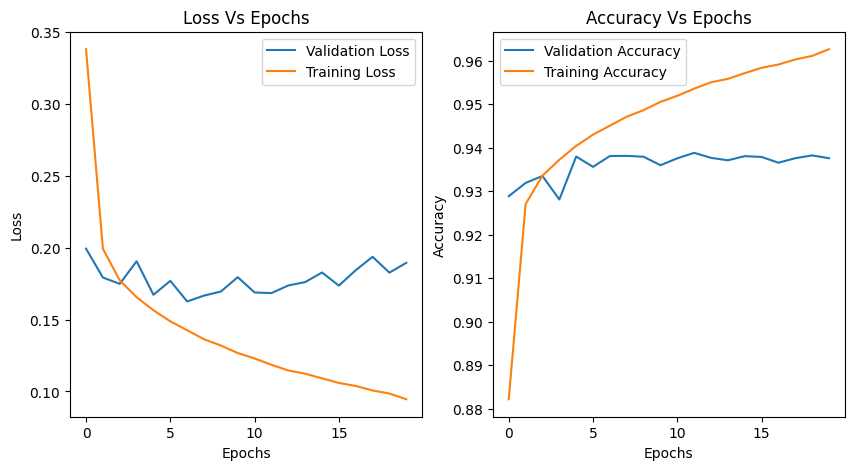

In [ ]:
# Plotting the Validation Loss N Validation Accuracy against the number of Epochs:
import pandas as pd
data = pd.DataFrame(history_240_frozen_b7.history)
(a,b) = data.shape

plt.figure(figsize=(10,5))
plt.subplot(1,2,1)
plt.plot(range(a), data['val_loss'], label = "Validation Loss")
plt.plot(range(a), data['loss'], label = "Training Loss")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.title("Loss Vs Epochs")
plt.legend()

plt.subplot(1,2,2)
plt.plot(range(a), data['val_accuracy'], label = "Validation Accuracy")
plt.plot(range(a), data['accuracy'], label = "Training Accuracy")
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.title("Accuracy Vs Epochs")
plt.legend()

In [ ]:
from keras.models import load_model
model_path = '/content/tile_b7_sm_model_frozen.h5'
model = load_model(model_path)

In [ ]:
test_images_list = []
test_masks_list = []

for images, masks in validation_dataset.take(10):
    for i in range(images.shape[0]):
        img = images[i]
        mask = masks[i]
        test_images_list.append(img)
        test_masks_list.append(mask)

In [ ]:
# Saving the data in numpy arrays
test_dataset_images = np.array(test_images_list)
test_dataset_masks = np.array(test_masks_list)

In [ ]:
test_dataset = tf.data.Dataset.from_tensor_slices((test_dataset_images))

In [ ]:
# Now we need to convert from TensorSliceDataset to BatchDataset as expected by the model:
dataset = test_dataset.batch(batch_size=1)

In [ ]:
predicted_masks = model.predict(dataset)

160/160 [==============================] - 8s 24ms/step


In [ ]:
pred_masks = np.argmax(predicted_masks, axis = 3)

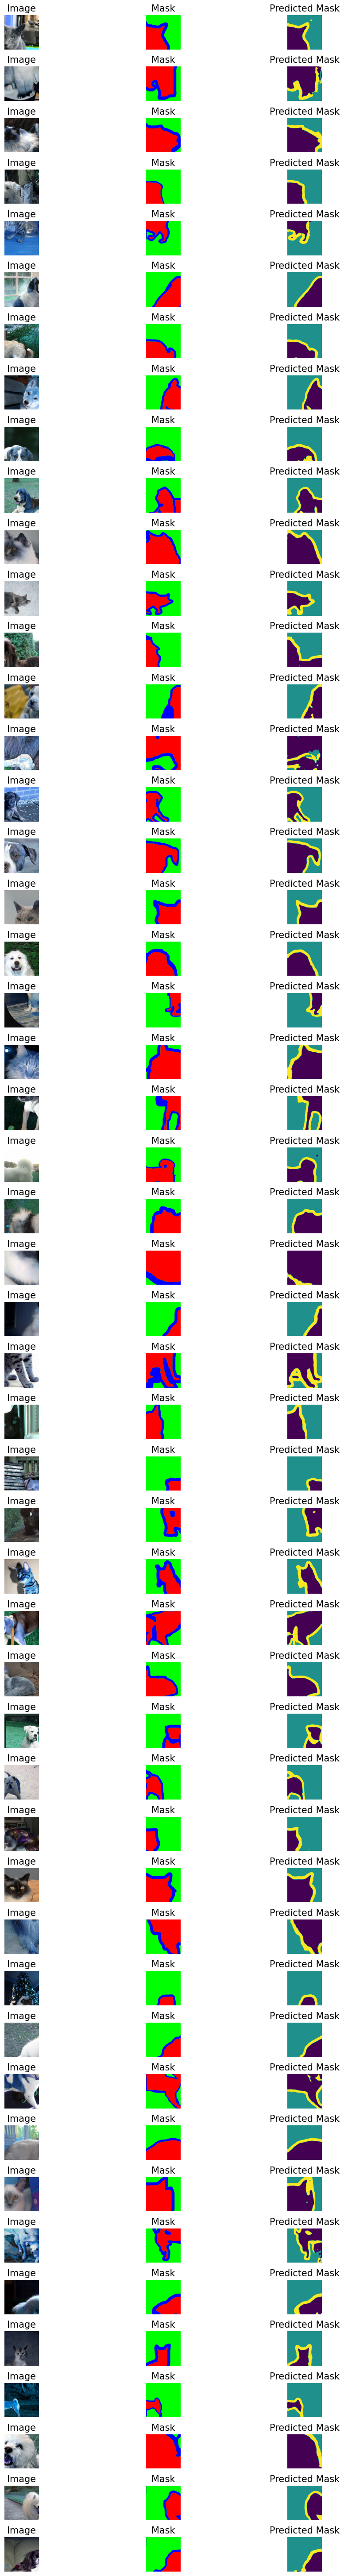

In [ ]:
# Define the size of each subplot image
subplot_size = (3, 3)
figsize = (subplot_size[0]*4, subplot_size[1]*25)

# Iterate over the first 20 images, True masks and predicted masks
fig, axes = plt.subplots(nrows=50, ncols=3, figsize=figsize)

for i in range(50):
    # Plot the image on the top row of the subplot
    axes[i, 0].imshow(test_dataset_images[i])
    axes[i, 0].set_title('Image', fontsize=15)
    axes[i, 0].axis('off')

    # Plot the mask on the middle row of the subplot
    axes[i, 1].imshow(test_dataset_masks[i])
    axes[i, 1].set_title('Mask', fontsize=15)
    axes[i, 1].axis('off')

    # Plot the predicted mask on the bottom row of the subplot
    axes[i, 2].imshow(pred_masks[i])
    axes[i, 2].set_title('Predicted Mask', fontsize=15)
    axes[i, 2].axis('off')

# Adjust the size and spacing of the subplots
fig.subplots_adjust(hspace=0.5, wspace=0.1)


# Show the plot
plt.show()